# Plots for the colored MNIST.

## 1. Imports

In [1]:
import os, sys
sys.path.append("..")

from src import distributions

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, RandomSampler, DataLoader

import numpy as np
import math
import pdb
import gc

from sklearn.datasets import make_blobs, make_swiss_roll
from matplotlib import pyplot as plt
from src.cunet import CUNet
from src.tools import load_dataset

from tqdm import tqdm
from IPython.display import clear_output

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""
torch.set_num_threads(2)

## 2. Config

In [3]:
DEVICE_IDS = [1]

DATASET1, DATASET1_PATH = 'MNIST-colored_2', '/home/data/MNIST'
DATASET2, DATASET2_PATH = 'MNIST-colored_3', '/home/data/MNIST'

T_ITERS = 10
D_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 64
UNET_BASE_FACTOR = 48

N_STEPS = 10
EPSILON = 0
TIME_DIM = 128
CONSTANT_TIME = False
USE_POSITIONAL_ENCODING = True
RESNET_GENERATOR = False
INTEGRAL_SCALE = 1/(3*IMG_SIZE*IMG_SIZE)
ONE_STEP_INIT_ITERS = 0
T_GRADIENT_MAX_NORM = float("inf")
D_GRADIENT_MAX_NORM = float("inf")
PREDICT_SHIFT = False
SMART_INTERVALS = False
INTERVAL_SHRINK_START_TIME = 0.98
LAST_STEP_NOISE_STD = 1e-3
USE_GRADIENT_CHECKPOINT = False
PREDICT_NOISE_AT_LAST_STEP = False
N_LAST_STEPS_WITHOUT_NOISE = 1
TRACK_VAR_INTERVAL = 10
IMPROVED_DIFFUSION = False
USE_CHECKPOINTS_INSIDE_MODEL = False
EPSILON_SCHEDULER_LAST_ITER = 20000
USE_EXPONENTIAL_AVERAGE_MODEL = False
DISTINCT_SHIFT_MODELS = False

DATASET1_CHANNELS = 3
DATASET2_CHANNELS = 3
GRAY_PLOTS = False
BATCH_SIZE = 64
STEPS_TO_SHOW = 10

PLOT_INTERVAL = 500
COST = 'schrodinger'
CPKT_INTERVAL = 500
MAX_STEPS = 100001
SEED = 0xBADBEEF

GAMMA0, GAMMA1 = 0.0, 0.333
GAMMA_ITERS = 20000

CONTINUE = -1

## 3. Code for models

In [4]:
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return F.silu(input)


class TimeEmbedding(nn.Module):
    def __init__(self, dim, scale):
        super().__init__()

        self.dim = dim
        self.scale = scale

        inv_freq = torch.exp(
            torch.arange(0, dim, 2, dtype=torch.float32) * (-math.log(10000) / dim)
        )

        self.register_buffer("inv_freq", inv_freq)

    def forward(self, input):
        shape = input.shape
        
        input = input*self.scale + 1
        sinusoid_in = torch.ger(input.view(-1).float(), self.inv_freq)
        pos_emb = torch.cat([sinusoid_in.sin(), sinusoid_in.cos()], dim=-1)
        pos_emb = pos_emb.view(*shape, self.dim)

        return pos_emb


class SDE(nn.Module):
    def __init__(self, shift_model, epsilon, n_steps, time_dim, is_resnet_generator, times):
        super().__init__()
        self.shift_model = shift_model
        self.epsilon = epsilon
        self.n_steps = n_steps
        self.is_resnet_generator = is_resnet_generator
        self.times = times
        self.time_to_step = {str(round(time, 3)): i for i, time in enumerate(times)}
        
        self.time = nn.Sequential(
            TimeEmbedding(time_dim, scale=n_steps),
            nn.Linear(time_dim, time_dim),
            Swish(),
            nn.Linear(time_dim, time_dim),
        )
    
    def forward(self, x0):            
        if self.is_resnet_generator:
            trajectory, shifts = self.shift_model(x0)

            return trajectory, times, shifts
        else:
            t0 = 0.0
            trajectory = [x0]
            times = [t0]
            shifts = []

            x, t = x0, t0
            
            for i, t_next in enumerate(self.times[1:]):                
                if i >= len(self.times[1:]) - N_LAST_STEPS_WITHOUT_NOISE:
                    x, shift = self._step(x, t, t_next - t, add_noise=False)
                else:
                    x, shift = self._step(x, t, t_next - t, add_noise=True)
                
                t = t_next

                trajectory.append(x)
                times.append(t)
                shifts.append(shift)
                
            trajectory = torch.stack(trajectory, dim=1)
            times = torch.tensor(times)[None, :].repeat(trajectory.shape[0], 1)
            shifts = torch.stack(shifts, dim=1)

            return trajectory, times, shifts
    
    def _step(self, x, t, delta_t, add_noise=True):
        if PREDICT_SHIFT:
            shift_dt = self._get_shift(x, t)
            shifted_x = x + shift_dt
            shift = shift_dt/(torch.tensor(delta_t))
        else:
            shifted_x = self._get_shift(x, t)
            shift = (shifted_x - x)/(torch.tensor(delta_t))
        noise = self._sample_noise(x, delta_t)
        
        if add_noise:
            return shifted_x + noise, shift
        
        return shifted_x, shift
    
    def _get_shift(self, x, t):
        batch_size = x.shape[0]
        
        if CONSTANT_TIME:
            t = 0.0
        
        if IMPROVED_DIFFUSION:
            t = torch.tensor(t).repeat(batch_size)
        elif DISTINCT_SHIFT_MODELS:
            step = self.time_to_step[str(round(t, 3))]
            t = torch.tensor(0.0).repeat(batch_size)[:, None, None, None]
            return self.shift_model[step](x, t)
        elif USE_POSITIONAL_ENCODING:
            t = torch.tensor(t).repeat(batch_size)
            t = t
            t = self.time(t)
            t = t[:, :, None, None]
        else:
            t = torch.tensor(t).repeat(batch_size)[:, None, None, None]
            if x.device.type == "cuda":
                t = t
        
        if USE_GRADIENT_CHECKPOINT:
            return torch.utils.checkpoint.checkpoint(self.shift_model, x, t)
        
        return self.shift_model(x, t)
        
    def _sample_noise(self, x, delta_t):
        noise = math.sqrt(self.epsilon)*math.sqrt(delta_t)*torch.randn(x.shape)
        
        if x.device.type == "cuda":
            noise = noise
        return noise
            
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon
        

def integrate(values, times):
    deltas = times[1:] - times[:-1]
    if values.device.type == "cuda":
        deltas = deltas
    return (values*deltas[None, :]).sum(dim = 1)


def calculate_noise_norm(dim, n_steps, epsilon):
    n = dim
    dt = 1/n_steps
    sigma = math.sqrt(dt)*math.sqrt(epsilon)

    return n_steps*(math.exp(math.log(sigma) + math.log(math.sqrt(2)) + math.lgamma((n+1)/2) - math.lgamma(n/2)))


def calculate_time_intervals_by_std(n_steps, epsilon, shrink_start_time, end_std):
    times = np.linspace(0, shrink_start_time, n_steps + 1).tolist()
    delta_t = shrink_start_time/n_steps
    
    std = np.sqrt(epsilon)*np.sqrt(delta_t)

    while std > end_std and times[-1] < 1:
        delta_t /= 10
        times.append(times[-1] + delta_t*10 - delta_t)

        std = np.sqrt(epsilon)*np.sqrt(delta_t)
    
    if times[-1] < 1:
        times.append(1)
    
    return times

if SMART_INTERVALS:
    times = calculate_time_intervals_by_std(N_STEPS, EPSILON, INTERVAL_SHRINK_START_TIME, LAST_STEP_NOISE_STD)
else:
    times = calculate_time_intervals_by_std(N_STEPS, EPSILON, 1, LAST_STEP_NOISE_STD)

## 4. Samplers initialization

In [5]:
X_sampler, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH,
                                         img_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                         device="cpu")
Y_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH,
                                         img_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                         device="cpu")
    
torch.cuda.empty_cache(); gc.collect()
clear_output()

## 5. Code for plotting ENOT and discrete optimal transport (DOT) model outputs 

In [6]:
def plot_images(T, sampler, n_x, n_samples, epsilon, inds=(1, 2, 3, 4)):
    X = torch.stack([sampler.loader.dataset[ind][0] for ind in inds], dim = 0)
    print(T.epsilon)
    T_X = torch.stack([T(X)[0][:, -1] for i in range(n_samples)], dim=1)
    T_X = T_X.detach().permute(0,1,3,4,2).mul(0.5).add(0.5).numpy().clip(0,1)
    X = X.permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)
    
    fig, axes = plt.subplots(n_x, n_samples+1, figsize=(2.8, 3), dpi=450)
    
    for i in range(n_x):
        ax = axes[i][0]
        ax.imshow(X[i])
        
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        
        if i == 0:
            ax.set_title(r"$X \sim \mathbb{P}_0$")
        
        for j in range(0, n_samples):

            ax = axes[i][j+1]
            ax.imshow(T_X[i][j])
            
            ax.get_xaxis().set_visible(False)
            ax.set_yticks([])
            
            if i == 0:
                ax.set_title(r"$T_f(X)$")
            
    fig.tight_layout(pad=0.001)
    
    plt.savefig(f"../pics/MNIST_{epsilon}_samples_results.png")

In [7]:
def plot_dot_images(mapping, X_sampler, Y_sampler, n_x, n_samples, epsilon, inds=(1, 2, 3, 4)):
    n_x = len(inds)
    K = n_samples
    K_in = n_x
    current_map = mapping
    
    N = 1000
    
    X = X_sampler.loader.dataset[:N][0]
    Y = Y_sampler.loader.dataset[:N][0]

    fig, axes = plt.subplots(K_in, K+1, figsize=(2.8, 3), dpi=450)

    for k in range(K_in):
        
        original_img = (X[inds[k]]*0.5 + 0.5).permute(1, 2, 0)

        axes[k, 0].imshow(original_img)
        axes[k, 0].get_xaxis().set_visible(False)
        axes[k, 0].set_yticks([])

        tranposrt_idx = np.random.choice(np.arange(N), size=K, replace=True, p=current_map[inds[k]]/(current_map[inds[k]].sum()))
        
        if k == 0:
            axes[k, 0].set_title(r"$X \sim \mathbb{P}_0$")

        for i in range(1, K+1):

            img = (Y[tranposrt_idx[i-1]]*0.5 + 0.5).permute(1, 2, 0)
            axes[k, i].imshow(img)
            axes[k, i].get_xaxis().set_visible(False)
            axes[k, i].set_yticks([])
            
            if k == 0:
                axes[k, i].set_title(r"$DOT(X)$")
            
    fig.tight_layout(pad=0.001)
    
    plt.savefig(f"../pics/MNIST_dot_{epsilon}_samples_results.png")
    
def plot_trajectories(models, epsilons, sampler, n_x):
    fig, axes = plt.subplots(n_x, n_samples+1, figsize=(6.7, 2), dpi=400)
    
    X = sampler.sample(1)
    
    for i in range(n_x):
        T = models[i]
        
    
        T_X = T(X)[0][:, 1:]
        T_X = T_X.detach().permute(0,1,3,4,2).mul(0.5).add(0.5).numpy().clip(0,1)
        X_img = X.permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)
        
        ax = axes[i][0]
        ax.imshow(X_img[0])
        
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        
        if i == 0:
            ax.set_title(r"$X \sim \mathbb{P}_0$")
        
        ax.set_ylabel(fr"$\epsilon=${epsilons[i]}")
        
        for j in range(0, n_samples):
            ax = axes[i][j+1]
            ax.imshow(T_X[0][j])
            
            ax.get_xaxis().set_visible(False)
            ax.set_yticks([])
            
            if i == 0:
                ax.set_title(fr"t={round(0.1*(j+1), 1)}")
            
    fig.tight_layout(pad=0.001)
    
    plt.savefig(f"../pics/MNIST_trajectories_results.png")

## 6. DOT plotting

### DOT mappings loading

In [15]:
mappings = []
epss = [0, 1, 10]
paths = [f"../discrete_transport_mappings/eps_{eps}" for eps in epss]

for path in paths:
    with open(path, "rb") as f:
        mappings.append(np.load(path).astype("float64"))

### DOT with $\epsilon = 0$

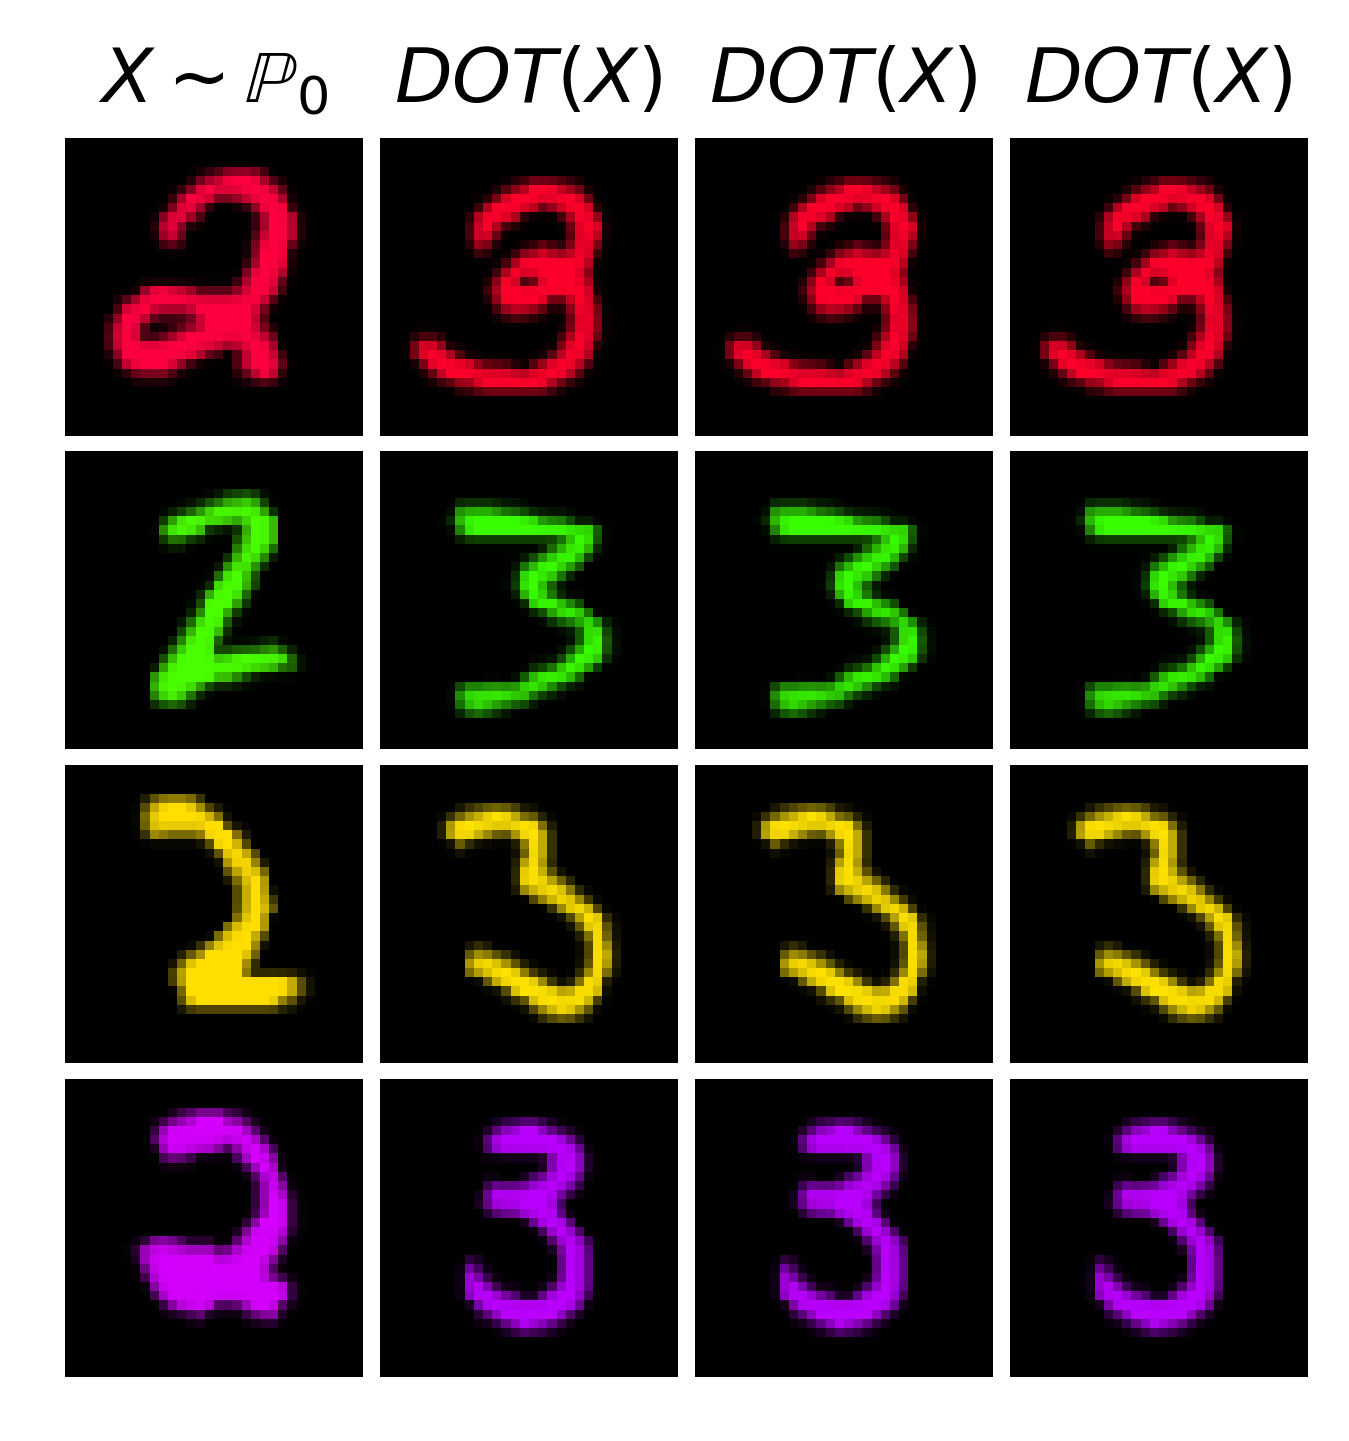

In [16]:
plot_dot_images(mappings[0], X_test_sampler, Y_test_sampler, 4, 3, 0, inds=(10, 24, 20, 25))

### DOT with $\epsilon = 1$

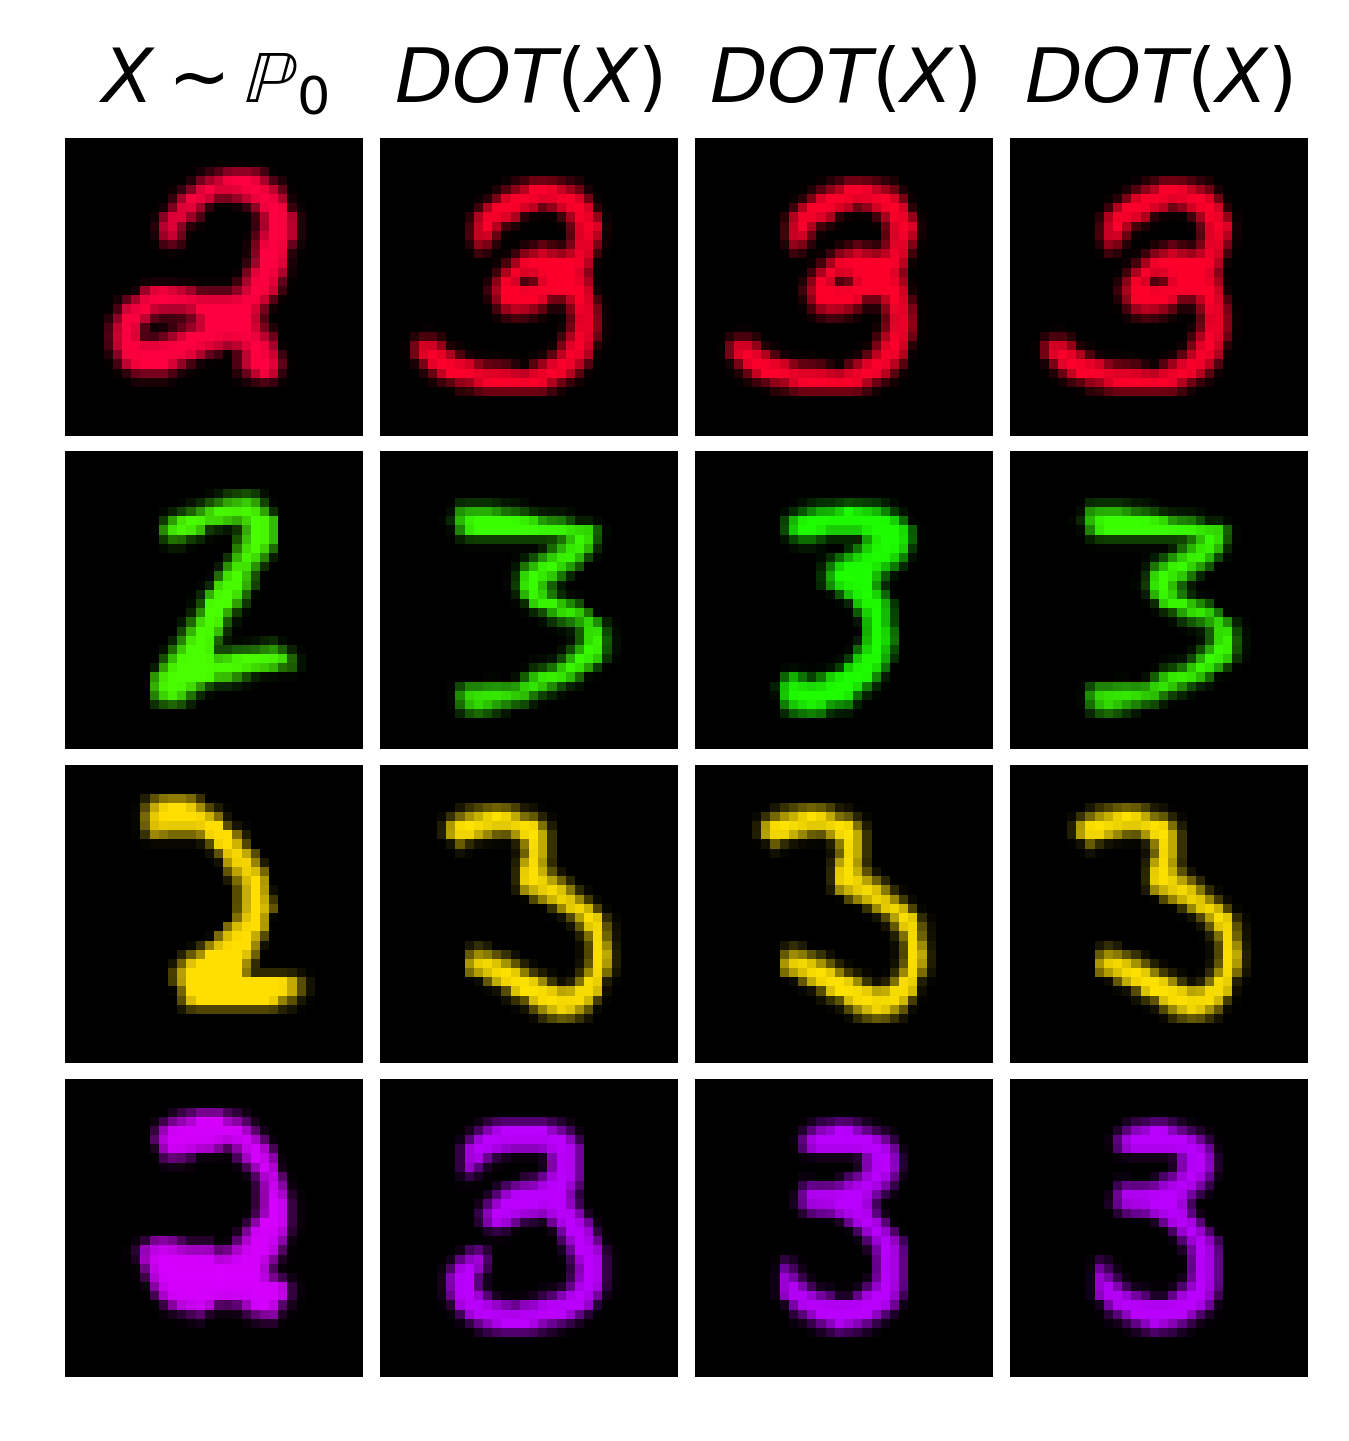

In [17]:
plot_dot_images(mappings[1], X_test_sampler, Y_test_sampler, 4, 3, 1, inds=(10, 24, 20, 25))

## DOT with $\epsilon = 10$

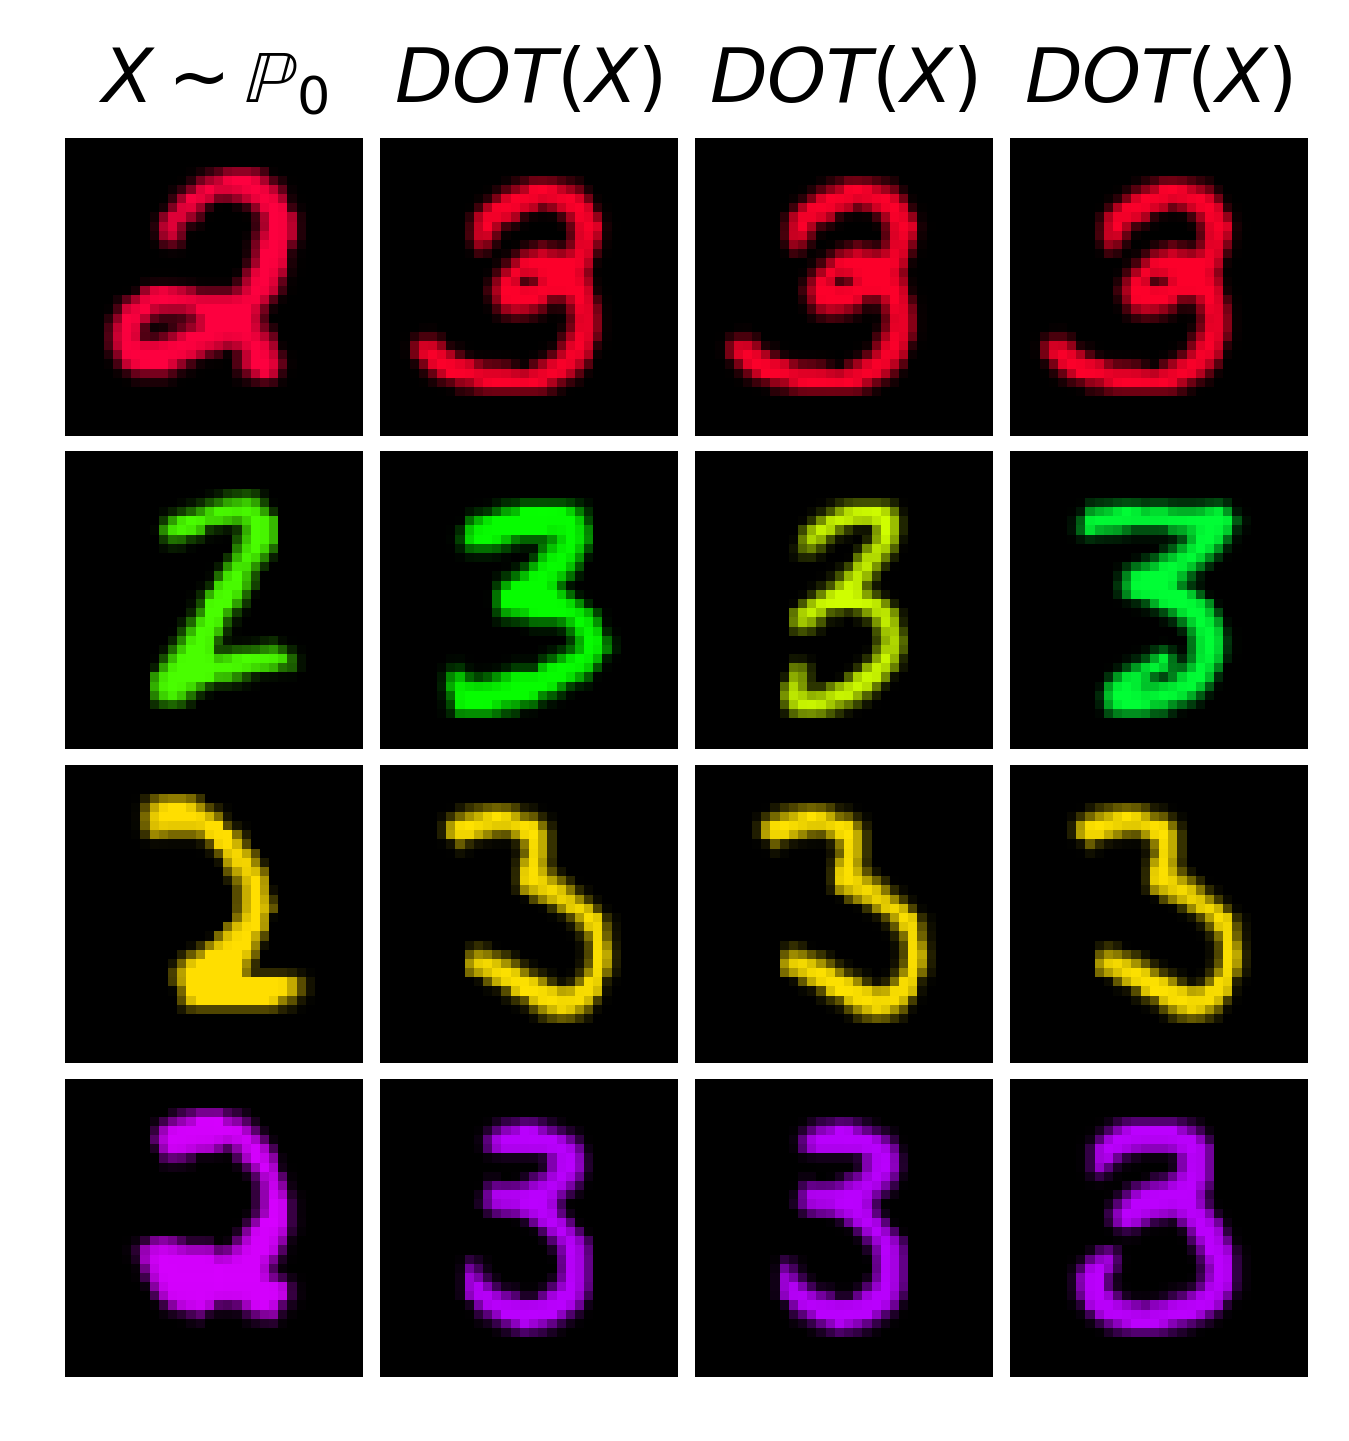

In [18]:
plot_dot_images(mappings[2], X_test_sampler, Y_test_sampler, 4, 3, 10, inds=(10, 24, 20, 25))

## 7. ENOT plotting

### ENOT checkpoints loading

In [20]:
steps_to_load = [19999, 20499, 73499]
# pathes = [
#     "/home/n.gushchin/SchrodingerBridge/checkpoints/schrodinger/MNIST-colored_2_MNIST-colored_3_T10_DISTINCT_SHIFT_MODELS_False_PREDICT_SHIFT_False_BASE_FACTOR_48_STEPS_10_EPSILON_0_IMG_SIZE32/MNIST-colored_2_MNIST-colored_3_32",
#     "/home/n.gushchin/SchrodingerBridge/checkpoints/schrodinger/MNIST-colored_2_MNIST-colored_3_T10_DISTINCT_SHIFT_MODELS_False_PREDICT_SHIFT_False_BASE_FACTOR_48_STEPS_10_EPSILON_1_IMG_SIZE32/MNIST-colored_2_MNIST-colored_3_32",
#     "/home/n.gushchin/SchrodingerBridge/checkpoints/schrodinger/MNIST-colored_2_MNIST-colored_3_T10_IMPROVED_DIFFUSION_False_BASE_FACTOR_48_STEPS_10_EPSILON_10_IMG_SIZE32/MNIST-colored_2_MNIST-colored_3_32"
# ]
pathes = [
    "../enot_checkpoints/colored_MNIST/",
    "../enot_checkpoints/colored_MNIST/",
    "../enot_checkpoints/colored_MNIST/"
]
epsilons = [0, 1, 10]

models = []
for epsilon, path, step_to_load in zip(epsilons, pathes, steps_to_load):
    T = CUNet(3, 3, TIME_DIM, base_factor=48)
    T = SDE(T, epsilon, len(times) - 1, TIME_DIM, is_resnet_generator=RESNET_GENERATOR, times=times)
    
    print(step_to_load)
    T.load_state_dict(torch.load(os.path.join(path, f'T_{SEED}_{step_to_load}.pt'), map_location=torch.device('cpu')))
    models.append(T)

19999
20499
73499


### ENOT with $\epsilon = 0$

0


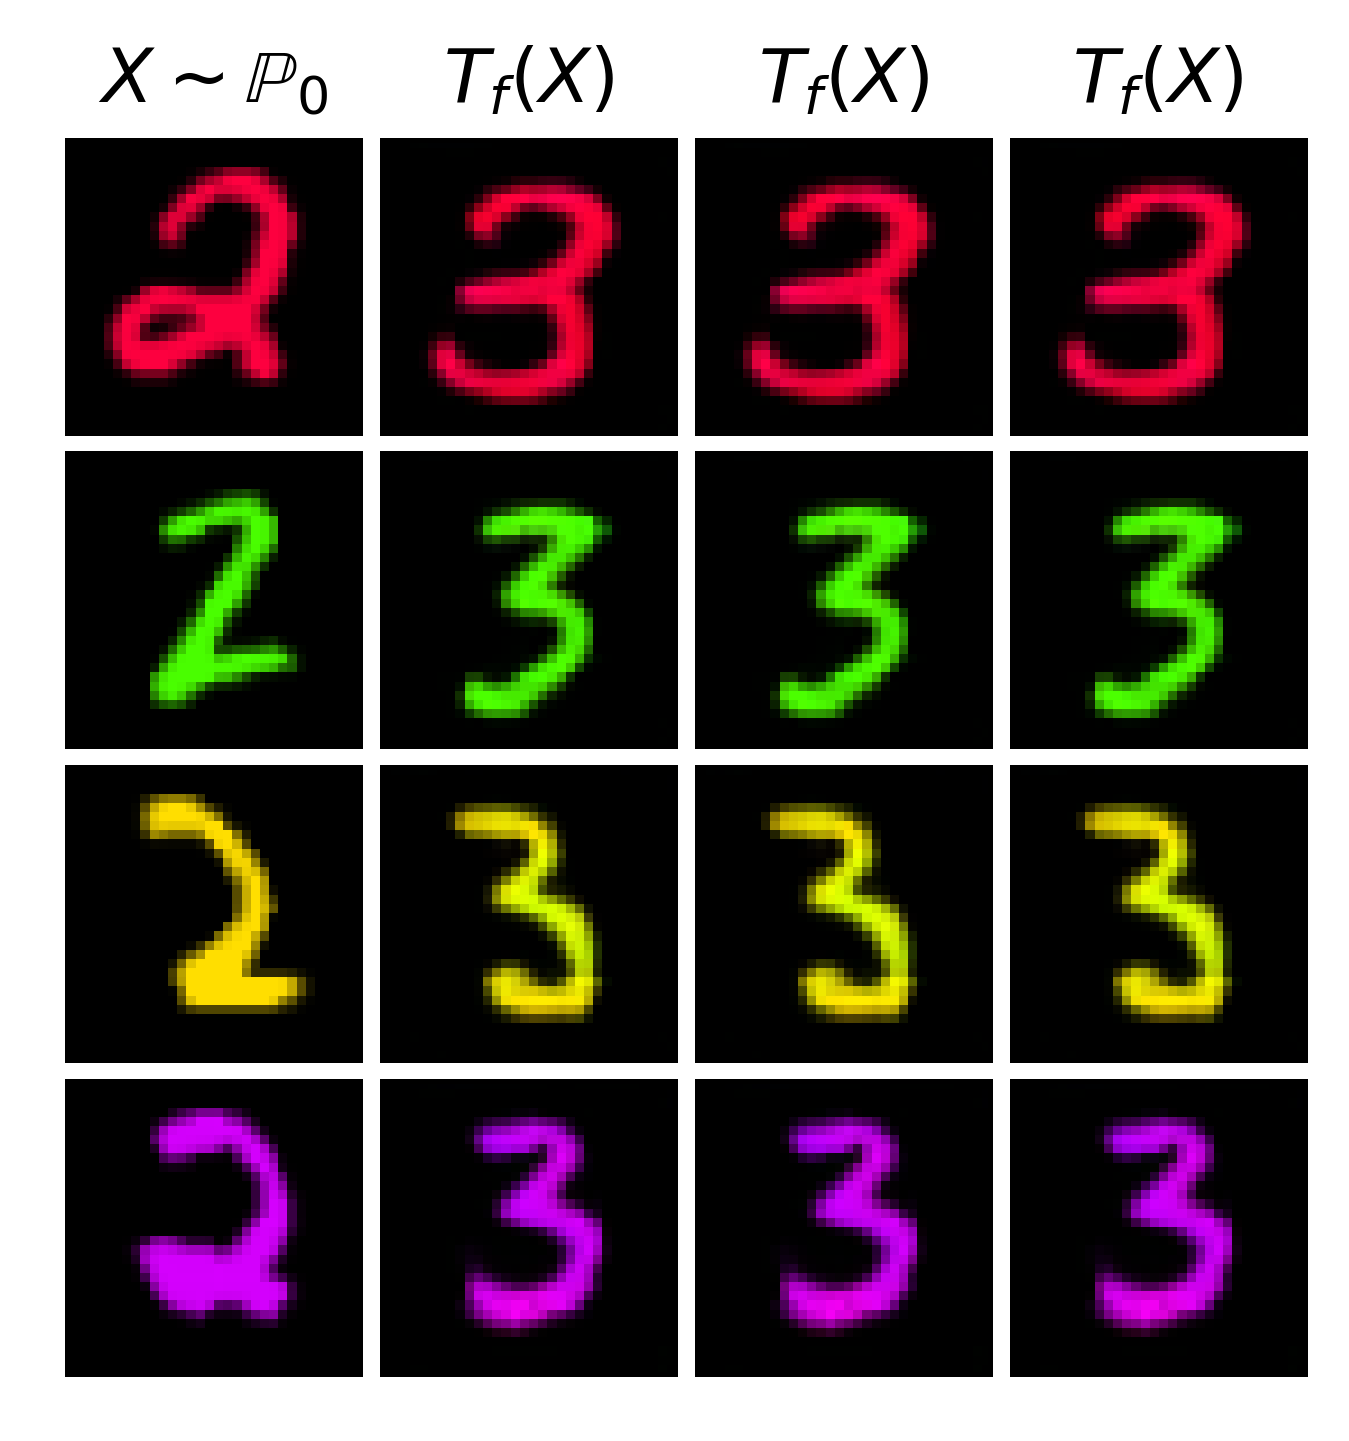

In [22]:
plot_images(models[0], X_test_sampler, 4, 3, 0, inds=(10, 24, 20, 25))

### ENOT with $\epsilon = 1$

1


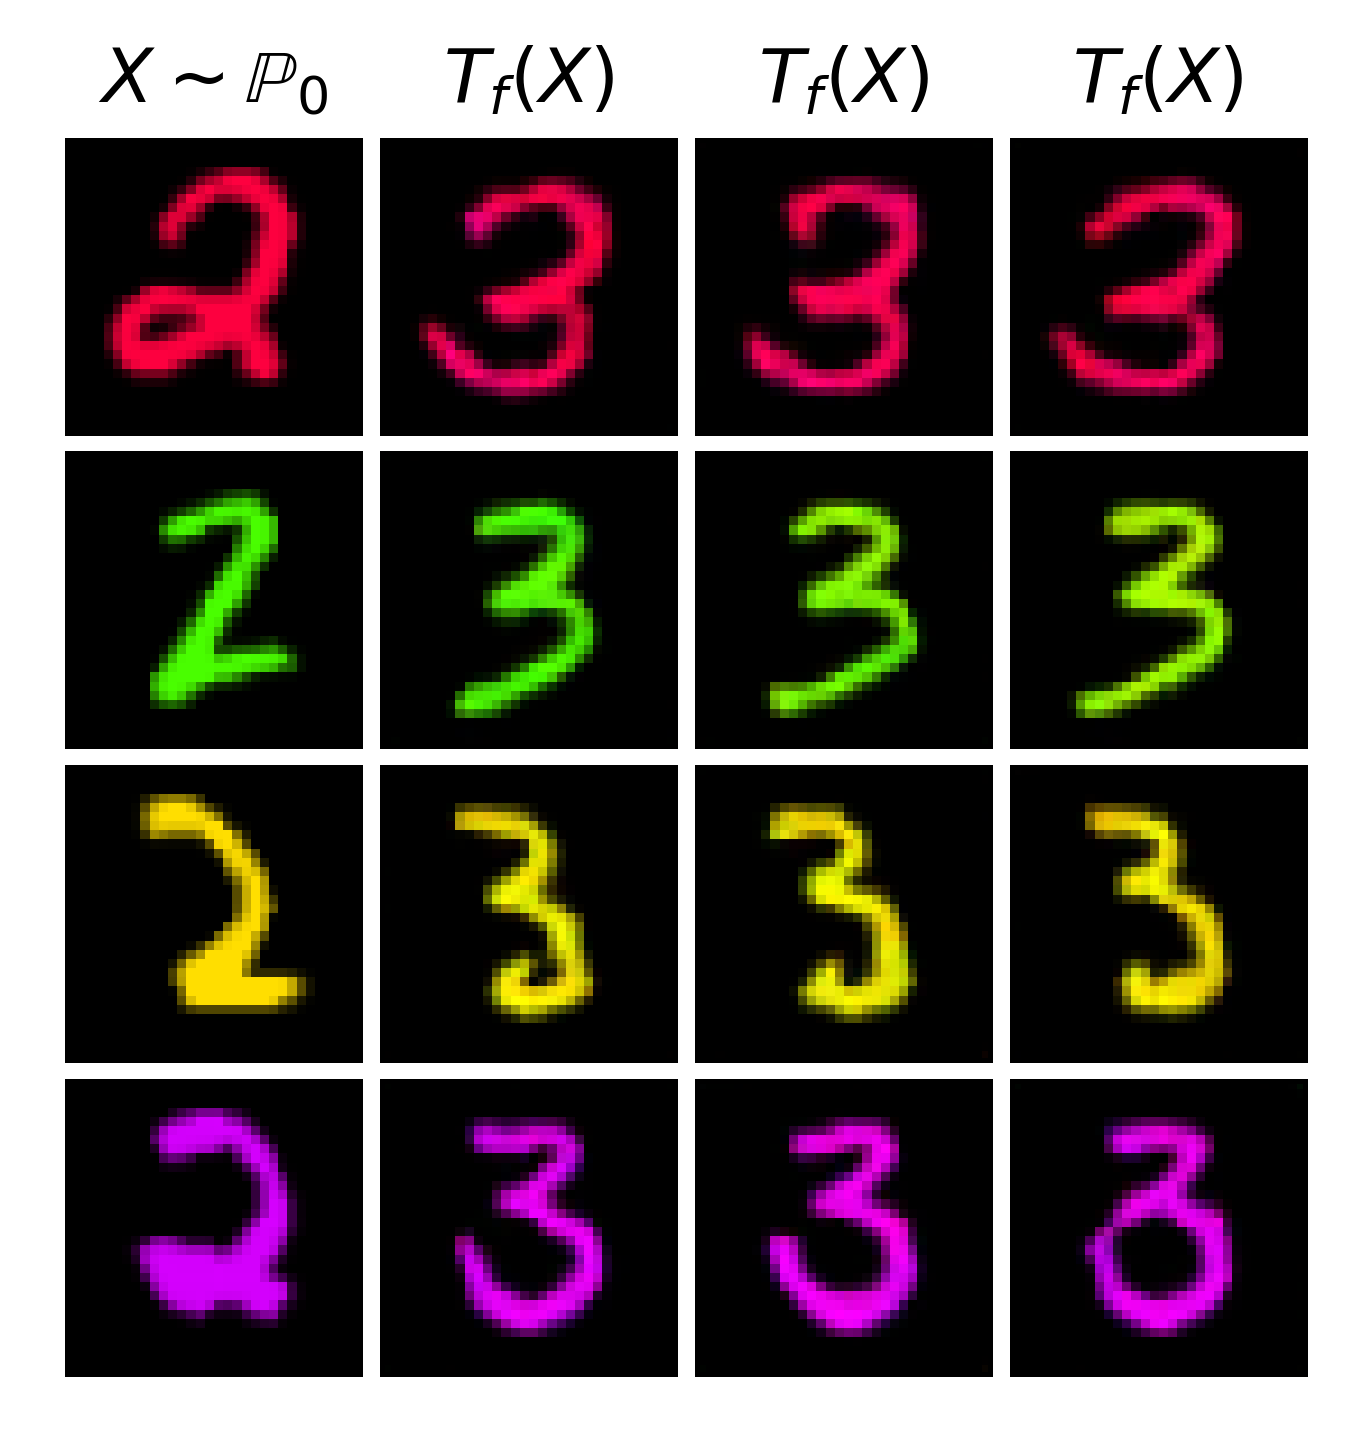

In [23]:
plot_images(models[1], X_test_sampler, 4, 3, 1, inds=(10, 24, 20, 25))

### ENOT with $\epsilon = 10$

10


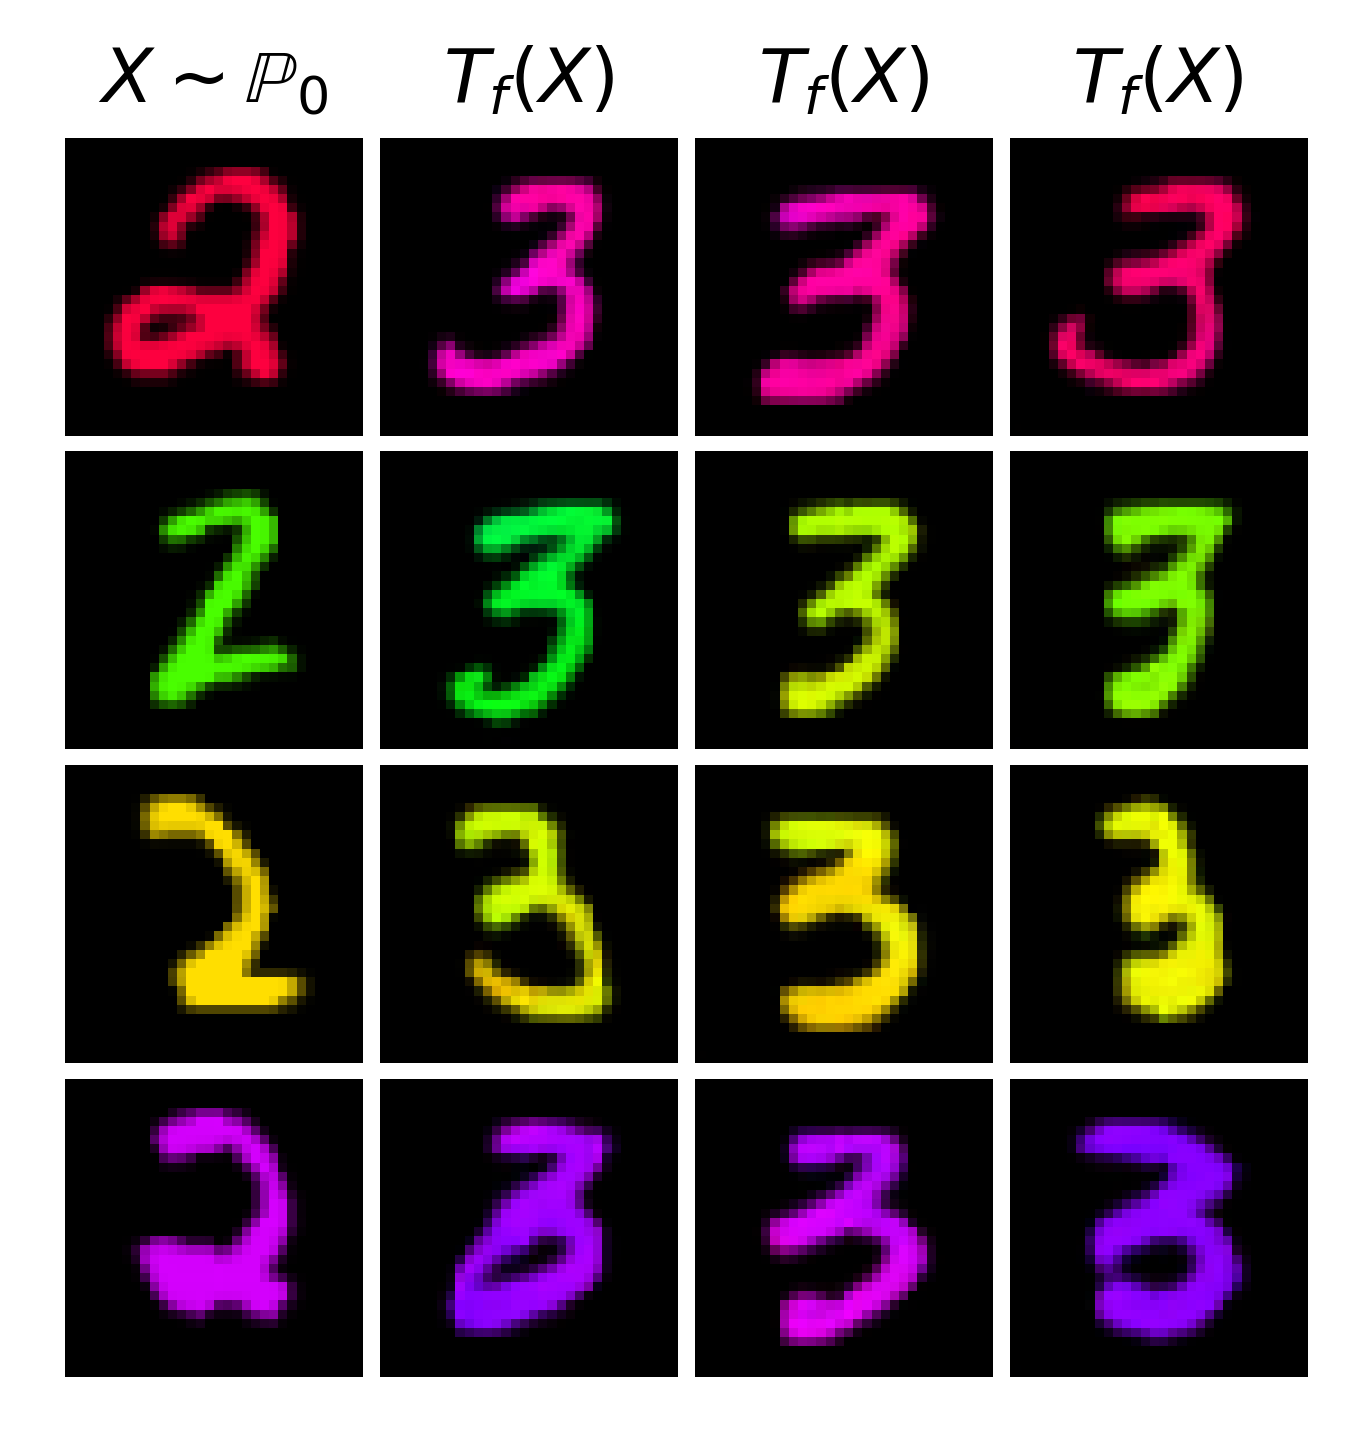

In [25]:
plot_images(models[2], X_test_sampler, 4, 3, 10, inds=(10, 24, 20, 25))

### ENOT learned trajectories for different $\epsilon$

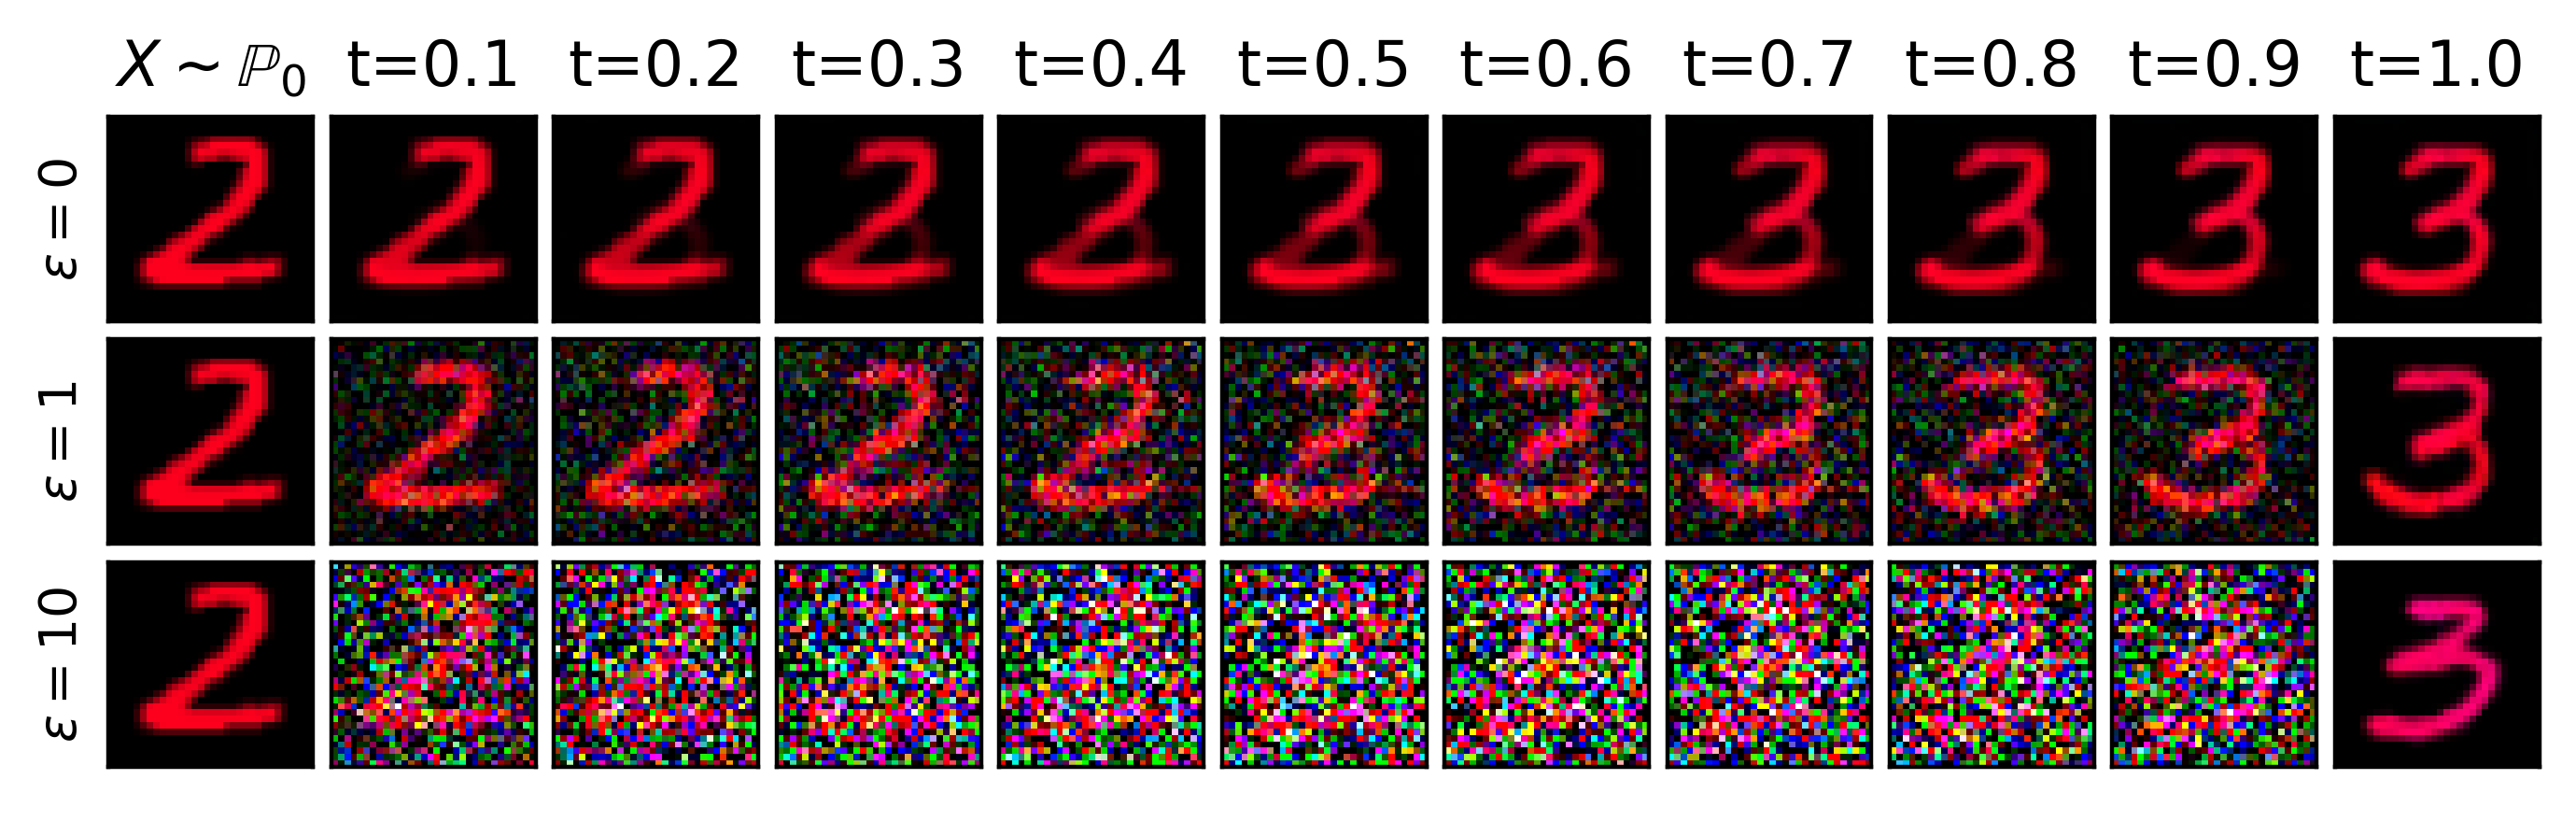

In [340]:
plot_trajectories(models, epsilons, X_test_sampler, 3)